In [42]:
import torch
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import Dataset
import json
import glob
import sklearn.metrics as metrics
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.metrics import precision_recall_curve

In [28]:
# In[]:
    
data_embeddings = torch.load('few_shot_mapping.pth', map_location=torch.device('cpu'))
data_embeddings = data_embeddings.reset_index()
    

root_src = "../few_shot_dataset_split/"
train_src = 'train'
test_src = 'test'
val_src = 'val'
batchSize = 4
class_to_cluster_embedding={}

print("Creating Target Embedding Data")
for index, row in data_embeddings.iterrows():
    class_folder = row['Label'] 
    class_to_cluster_embedding[class_folder] = {}
    class_to_cluster_embedding[class_folder][0] = row['Level0_Embeddings']
    class_to_cluster_embedding[class_folder][1] = row['Level1_Embeddings']
    class_to_cluster_embedding[class_folder][2] = row['Level2_Embeddings']

Creating Target Embedding Data


In [32]:
k = ['american_bobtail', 'american_paint_horse', 'british_shorthair_cat', 'burmese_cat', 'camarillo_white_horse', 'catfish', 'crow', 'cuckoo', 'deer', 'friesian_horse', 'giraffe', 'ibis', 'kingfisher', 'kiwi_bird', 'parrot', 'puffbird', 'ragdoll_cat', 'rhinoceros', 'sparrow', 'tuna']

In [38]:
class ImageNetDataset(Dataset):
    def __init__(self, root, split, level, transform=None):
        self.samples = []
        self.target_labels = []
        self.target_embeddings = []
        self.transform = transform
        self.syn_to_class = {}
        self.level = level
#         with open(os.path.join(root, "imagenet_class_index.json"), "rb") as f:
#             json_file = json.load(f)
#             for class_id, v in json_file.items():
#                 self.syn_to_class[v[0]] = int(class_id)
        for i in range(len(k)):
            self.syn_to_class[k[i]] = i+1
        samples_dir = os.path.join(root, split)
        for entry in os.listdir(samples_dir):
            syn_id = entry
            if syn_id not in class_to_cluster_embedding:
                continue
            
            sample_path = os.path.join(samples_dir, entry)
            for filename in glob.glob(sample_path+"/*"): #assuming gif
                im=Image.open(filename).convert('RGB')
                sample = self.transform(im)
            
                target_label = self.syn_to_class.get(syn_id,syn_id)

                target_embedding = class_to_cluster_embedding[syn_id][self.level]
                    
                self.samples.append(sample)
                self.target_labels.append(torch.tensor(target_label))
                self.target_embeddings.append(torch.tensor(target_embedding))

        zipped = list(zip(self.samples, self.target_embeddings))
        random.shuffle(zipped)
        self.samples, self.target_embeddings = zip(*zipped)

        
    def __len__(self):
            return len(self.samples)
    def __getitem__(self, idx):
            return self.samples[idx], self.target_embeddings[idx]


Using device: cpu
-------------------------
Starting LEVEL 0
Creating Traininig Data
Creating Validation Data
Creating Testing Data
Training 
Testing 


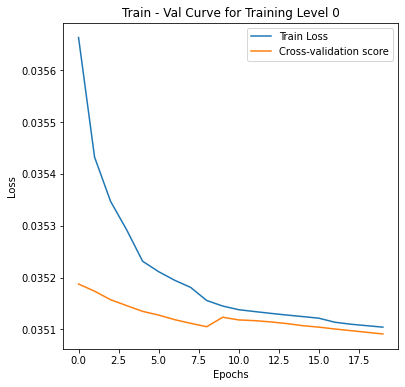

Average Level 0 Test cosine Similarity: 0.9249154
Average Level 0 Test loss: 0.035030693
-------------------------
Starting LEVEL 1
Creating Traininig Data
Creating Validation Data
Creating Testing Data
Training 


In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=0.07):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, image_embeddings, label_embeddings):

        distances = torch.cdist(image_embeddings, label_embeddings)
        negative_distances = (self.margin - distances).clamp(min=0)
        positive_distances = distances
        loss = torch.cat([positive_distances, negative_distances], dim=1).mean()
        return loss

# In[]: 
    
## LEVEL 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available
print(f"Using device: {device}")

    
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

data_transforms = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]
        )

# In[]: 
batchStep = 10
    
def trainEncoderForLevel(model, loss_fn, optimizer, scheduler, level, num_epochs, train_data, val_data, test_data):
    print("Training ")
    train_loss_lst = []
    val_loss_lst = []
    train_loss_per_Batch = []
    val_loss_per_Batch = []
    model.to(device)
    minLoss = 100
    for epoch in range(num_epochs):
        for i, (images, embeddings) in enumerate(train_data):
            target_embeddings = torch.unsqueeze(torch.unsqueeze(embeddings, dim=2), dim=2)
            image_embeddings = model(images.to(device))
            train_loss = loss_fn(image_embeddings.to(device), target_embeddings.to(device))
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            train_loss_lst.append(train_loss.item())
            if i>0 and i%batchStep == 0:
                with torch.no_grad():
                    for images, embeddings in val_data:
                        target_embeddings = torch.unsqueeze(torch.unsqueeze(embeddings, dim=2), dim=2)
                        image_embeddings = model(images.to(device))
                        val_loss = loss_fn(image_embeddings.to(device), target_embeddings.to(device))
                        if val_loss.item()<minLoss:
                            torch.save(model, str(level)+'_best_model.pth')
                            minLoss = val_loss.item()
                        val_loss_lst.append(val_loss.item())
                #scheduler.step(metrics = val_loss)
                train_loss_per_Batch.append(np.array(train_loss_lst).mean())
                val_loss_per_Batch.append(np.array(val_loss_lst).mean())
            if i>0 and i%100 == 0:
                print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
                  .format(int(i/10), 50, np.array(train_loss_lst).mean(), np.array(val_loss_lst).mean()))
    '''    
    '''
    model = torch.load(str(level)+'_best_model.pth',map_location=torch.device('cpu'))
        
    print("Testing ")
    cosine_sim = []
    cont_loss = []

    with torch.no_grad():
        for images, embeddings in val_data:
            predicted_embeddings = model(images.to(device))
            target_embeddings = torch.unsqueeze(torch.unsqueeze(embeddings, dim=2), dim=2)
            cos_sim = metrics.pairwise.cosine_similarity(predicted_embeddings.flatten(start_dim=1).cpu(), embeddings.flatten(start_dim=1).cpu())
            cosine_sim.extend(cos_sim)
#             print(cos_sim)
#             ground_truth_labels = torch.where(torch.Tensor(cos_sim) >= 0.5, torch.tensor(1), torch.tensor(0))
            
#             predictions = torch.where(torch.tensor(cos_sim) >= 0.5, torch.tensor(1), torch.tensor(0))

#             correct_predictions = torch.sum(predictions == ground_truth_labels)
#             total_predictions = len(ground_truth_labels)
#             accuracy = correct_predictions.item() / total_predictions
#             print(accuracy)
            
            loss = loss_fn(predicted_embeddings.cpu(), target_embeddings.cpu())
            cont_loss.append(loss)
#     plotPrecisionRecallCurve(precision, recall)
    plotTrainValCurve(train_loss_per_Batch, val_loss_per_Batch, level)
#     torch.save(model,"L"+str(level)+"_FEWSHOT_MODEL")

    print("Average Level " + str(level) + " Test cosine Similarity:", max(np.array(cosine_sim).flatten()))
    print("Average Level " + str(level) + " Test loss:", np.array(cont_loss).mean())  
        
    return model, train_loss_per_Batch, val_loss_per_Batch, cosine_sim, cont_loss
    
def plotTrainValCurve(train_loss, val_loss, level):
    num_batch = range(len(train_loss))
    plt.figure(figsize = (6,6))
    plt.plot(num_batch,train_loss, label="Train Loss")
    plt.plot(num_batch,val_loss, label="Cross-validation score")
    plt.xlabel('Epochs') 
    plt.ylabel("Loss") 
    plt.title('Train - Val Curve for Training Level ' + str(level))
    plt.legend()
    plt.show()


# In[]: 
'''
'''

print("-------------------------")
print("Starting LEVEL 0")
print("Creating Traininig Data")
train_dataset_l0 = ImageNetDataset(root_src, train_src, 0, data_transforms)
train_dataloader_l0 = DataLoader(
            train_dataset_l0,
            batch_size=batchSize, # may need to reduce this depending on your GPU 
            shuffle=False,
        )
print("Creating Validation Data")
val_dataset_l0 = ImageNetDataset(root_src, val_src, 0, data_transforms)
val_dataloader_l0 = DataLoader(
            val_dataset_l0,
            batch_size=batchSize, # may need to reduce this depending on your GPU 
            shuffle=False,
        )

print("Creating Testing Data")
test_dataset_l0 = ImageNetDataset(root_src, test_src, 0, data_transforms)
test_dataloader_l0 = DataLoader(
            test_dataset_l0,
            batch_size=batchSize, # may need to reduce this depending on your GPU 
            shuffle=False,
        )
'''
'''
# In[]: 
model_resnet152_l0 = torch.load("Pretrained Models Level wise/L0_ONESHOT_PRETRAINED_MODEL.pth",map_location=torch.device('cpu'))
    
contrastive_loss_fn_l0 = ContrastiveLoss()
optimizer_l0 = torch.optim.Adam(model_resnet152_l0.parameters(), lr= 0.01)
scheduler_l0 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_l0, mode='min', patience=3, factor=0.9)

num_epochs = 5
model_resnet152_l0, train_loss_l0, val_loss_l0, cosine_sim_l0, cont_loss_l0 = trainEncoderForLevel(model_resnet152_l0, contrastive_loss_fn_l0, optimizer_l0, scheduler_l0, 0, num_epochs, train_dataloader_l0, val_dataloader_l0, test_dataloader_l0)
# In[]: 
## LEVEL 1
print("-------------------------")
print("Starting LEVEL 1")
print("Creating Traininig Data")
train_dataset_l1 = ImageNetDataset(root_src, train_src, 1, data_transforms)
train_dataloader_l1 = DataLoader(
            train_dataset_l1,
            batch_size=batchSize, # may need to reduce this depending on your GPU 
            shuffle=False,
        )
print("Creating Validation Data")
test_dataset_l1 = ImageNetDataset(root_src, test_src, 1, data_transforms)
test_dataloader_l1 = DataLoader(
            test_dataset_l1,
            batch_size=batchSize, # may need to reduce this depending on your GPU 
            shuffle=False,
        )

print("Creating Testing Data")
val_dataset_l1 = ImageNetDataset(root_src, val_src, 1, data_transforms)
val_dataloader_l1 = DataLoader(
            val_dataset_l1,
            batch_size=batchSize, # may need to reduce this depending on your GPU 
            shuffle=False,
        )
'''
'''
model_resnet152_l1 = torch.load("Pretrained Models Level wise/L1_ONESHOT_PRETRAINED_MODEL.pth",map_location=torch.device('cpu'))

contrastive_loss_fn_l1 = ContrastiveLoss()
optimizer_l1 = torch.optim.Adam(model_resnet152_l1.parameters(), lr= 0.01)
scheduler_l1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_l1, mode='min', patience=3, factor=0.9)
num_epochs = 5

model_resnet152_l1, train_loss_l1, val_loss_l1, cosine_sim_l1, cont_loss_l1 = trainEncoderForLevel(model_resnet152_l1, contrastive_loss_fn_l1, optimizer_l1, scheduler_l1, 0, num_epochs, train_dataloader_l1 , val_dataloader_l1, test_dataloader_l1)

# In[ ]: 

## LEVEL 2
print("-------------------------")

print("Starting LEVEL 2")
print("Creating Traininig Data")
train_dataset_l2 = ImageNetDataset(root_src, train_src, 2, data_transforms)
train_dataloader_l2 = DataLoader(
            train_dataset_l2,
            batch_size=batchSize, # may need to reduce this depending on your GPU 
            shuffle=False,
        )
print("Creating Validation Data")
test_dataset_l2 = ImageNetDataset(root_src, test_src, 2, data_transforms)
test_dataloader_l2 = DataLoader(
            test_dataset_l2,
            batch_size=batchSize, # may need to reduce this depending on your GPU 
            shuffle=False,
        )

print("Creating Testing Data")
val_dataset_l2 = ImageNetDataset(root_src, val_src, 2, data_transforms)
val_dataloader_l2 = DataLoader(
            val_dataset_l2,
            batch_size=batchSize, # may need to reduce this depending on your GPU 
            shuffle=False,
        )
'''
'''
model_resnet152_l2 = torch.load("Pretrained Models Level wise/L2_ONESHOT_PRETRAINED_MODEL.pth",map_location=torch.device('cpu'))

contrastive_loss_fn_l2 = ContrastiveLoss()
optimizer_l2 = torch.optim.Adam(model_resnet152_l2.parameters(), lr= 0.01)
scheduler_l2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_l2, mode='min', patience=3, factor=0.9)
num_epochs = 5
     
model_resnet152_l2, train_loss_l2, val_loss_l2, cosine_sim_l2, cont_loss_l2  = trainEncoderForLevel(model_resnet152_l2, contrastive_loss_fn_l2, optimizer_l2, scheduler_l2, 0, num_epochs, train_dataloader_l2, val_dataloader_l2, test_dataloader_l2)